In [12]:
import numpy as np                        # computation, arrays, and seeded rng

import matplotlib.pyplot as plt           # used for display
from IPython.display import clear_output  # allows iterative display
import matplotlib.colors as mcolors       # colors for landscape types and fire
import time                               # used for display

# for making gifs
import imageio
import os

# Types of fuel:
# - Water                     : fuel per cell = 0 : ignition point = infinity : blue
# - Deadland                  : 0                 : infinity                  : grey
# - Grass                     : 6                 : 300 celsius               : `yellowgreen`
# - Shrubs                    : 15                : 450 celsius               : `mediumseagreen`
# - Sparse Forest             : 55                : 500 celsius               : `forestgreen`
# - Dense Forest              : 100               : 500 celsius               : `darkgreen`

# Should become a JSON file soon - or a database?
fuels = {'Water'   :  (0, float('inf'),"blue"),          # index 0
         'Deadland':  (0, float('inf'), "grey"),         # 1
         'Grass'   :  (6, 300, "yellowgreen"),           # 2
         'Shrubs'  :  (15, 370,"mediumseagreen"),        # 3
         'SForest' :  (55, 500,"forestgreen"),           # 4
         'DForest' :  (100, 500,"darkgreen")}            # 5

fuel_indices = {1. : (0, float('inf'),"blue"),
                2. : (0, float('inf'), "grey"),
                3. : (6, 300, "yellowgreen"),
                4. : (15, 370,"mediumseagreen"),
                5. : (55, 500,"forestgreen"),
                6. : (100, 500,"darkgreen")}

# We no longer have an acre class, our board is a numpy array of four floating point numbers at each entry:
#      board[i,j,0] is the fuel type float index
#      board[i,j,1], board[i,j,2], and board[i,j,3] are the color channels. No more copying to draw.

class board:
    
    def __init__(self, seed, size=(1000,1000), wind=np.array([0.,0.])):
        """
        Creates a board
        :param seed: used for all RNG
        :param size: first two dimensions of board size
        :return: None
        """
        self.board = np.zeros((size[0], size[1], 4), dtype=np.float64)
        self.seed  = seed
        
        # initially, the entire map is water (since the default float index is zero)
        # So we need the associated color channels
        color = mcolors.to_rgba(fuels['Water'][2])
        self.board[:,:,1] = color[0]
        self.board[:,:,2] = color[1]
        self.board[:,:,3] = color[2]
        
        # Will track fires by mapping coordinates to fire objects and back
        self.fires = {}
        
        # Store wind vector
        self.wind = wind
    
    def draw(self, fig):
        """
        Draws the board on a provided figure
        :param fig: matplotlib figure
        :return: None
        """
        plt.imshow(self.board[:,:,1:])
        clear_output(wait = True)
        display(fig)
        fig.clear()
        
    def get_adjacent(self, i, j):
        """
        Creates an iterator containing the adjacent indices to an index
        :param i: row index
        :param j: col index
        :return: adjacent indices
        """
        candidates = [(i-1,j-1),
                      (i-1,j),
                      (i-1,j+1),
                      (i,j-1),
                      (i,j+1),
                      (i+1,j-1),
                      (i+1,j),
                      (i+1,j+1)]
        if i == 0 or j == 0 or i == (self.board.shape[0] - 1) or j == (self.board.shape[1] - 1):
            return list(filter(lambda pair : pair[0] >= 0 and pair[1] >= 0
                               and pair[0] < self.board.shape[0] and pair[1] < self.board.shape[1], candidates))
        else:
            return candidates
    
    def get_adjacent2(self, i, j):
        """
        Creates an iterator containing the indices two spaces orthogonally away from an index
        :param i: row index
        :param j: col index
        :return: adjacent indices
        """
        candidates = [(i-2,j),
                      (i,j-2),
                      (i,j+2),
                      (i+2,j)]
        
        test = i in [0,1,self.board.shape[0] - 1,self.board.shape[0] - 2]
        test = test or j in [0,1,self.board.shape[1] - 1,self.board.shape[1] - 2] 
        if test:
            return list(filter(lambda pair : pair[0] >= 0 and pair[1] >= 0
                               and pair[0] < self.board.shape[0] and pair[1] < self.board.shape[1], candidates))
        else:
            return candidates
    
    def get_adjacent3(self, i, j):
        """
        Creates an iterator containing the indices a knight move from an index
        :param i: row index
        :param j: col index
        :return: adjacent indices
        """
        candidates = [(i-2,j-1),
                      (i-1,j-2),
                      (i-1,j+2),
                      (i+2,j-1),
                      (i+2,j+1),
                      (i-2,j+1),
                      (i+1,j+2),
                      (i+1,j-2)]
        test = i in [0,1,self.board.shape[0] - 1,self.board.shape[0] - 2]
        test = test or j in [0,1,self.board.shape[1] - 1,self.board.shape[1] - 2] 
        if test:
            return list(filter(lambda pair : pair[0] >= 0 and pair[1] >= 0
                               and pair[0] < self.board.shape[0] and pair[1] < self.board.shape[1], candidates))
        else:
            return candidates
    
    def grassland(self):
        """
        Quick test function - makes grassland
        :return: None
        """
        
        # assign board proper index
        self.board[:,:,0] = 3.
        
        # assign color
        color = mcolors.to_rgba(fuels['Grass'][2])
        self.board[:,:,1] = color[0]
        self.board[:,:,2] = color[1]
        self.board[:,:,3] = color[2]
        
    def forest(self):
        """
        Quick test function - makes a forest
        :return: None
        """
        
        # assign board proper index
        self.board[:,:,0] = 6.
        
        # assign color
        color = mcolors.to_rgba(fuels['DForest'][2])
        self.board[:,:,1] = color[0]
        self.board[:,:,2] = color[1]
        self.board[:,:,3] = color[2]
        
    def forest_grass(self):
        """
        Quick test function, half forest, half grass
        :return: None
        """
        for i in range(self.board.shape[0]):
            for j in range(self.board.shape[1]):
                if i > j:
                    # grass
                    self.board[i,j,0] = 3.
                    color = mcolors.to_rgba(fuels['Grass'][2])
                    self.board[i,j,1] = color[0]
                    self.board[i,j,2] = color[1]
                    self.board[i,j,3] = color[2]
                else:
                    # forest
                    self.board[i,j,0] = 6.
                    color = mcolors.to_rgba(fuels['DForest'][2])
                    self.board[i,j,1] = color[0]
                    self.board[i,j,2] = color[1]
                    self.board[i,j,3] = color[2]
        
    
    def populate(self, fig, mut = .8, stoch = .995):
        """
        Random land generation
        :param fig: matplotlib figure, this allows intermediate drawing
        :param mut: Mutation rate, float from 0 to 1. Inversely proportional to 'roundness' of land.
        :param stoch: float from 0 to 1. Essentially how "noisy" the land is
        """
        
        # Apply seed for reproducible generation
        np.random.seed(self.seed)
        
        # This array is used to track general land shape
        row_lim = self.board.shape[0]
        col_lim = self.board.shape[1]
        ids = -np.ones((row_lim, col_lim))
        
        fuel_opts = list(fuel_indices.keys())
        fuel_opts.remove(1.); fuel_opts.remove(2.)
        
        # Seed some random grasslands that will reproduce, populating via a genetic algorithm
        indices = {(np.random.randint(0,row_lim), np.random.randint(0, col_lim)) for _ in range(12)}
        for i, index in enumerate(indices):
            self.board[index[0], index[1], 0] = 3.
            color = mcolors.to_rgba(fuels['Grass'][2])
            self.board[index[0],index[1],1] = color[0]
            self.board[index[0],index[1],2] = color[1]
            self.board[index[0],index[1],3] = color[2]
            ids[index[0], index[1]] = i
        
        used_indices = set()
        
        while len(used_indices) < row_lim*col_lim:
            
            #self.draw(fig)
         
            new_indices = set()
            
            for i,j in indices:
                for ni, nj in self.get_adjacent(i, j):
                    if (new_idx := (ni, nj)) not in used_indices:
                        if np.random.rand() < mut:
                            new_indices.add(new_idx)
                            ids[ni, nj] = ids[i, j]
                        else:
                            new_indices.add((i,j))
                    
                    # river time?
                    # notes:
                    # - checking %5 and not %3 creates more lakes
                    # - %3 creates islands
                    if (ids[ni, nj] + ids[i, j]) % 2:
                        
                        # give this intersection cell a water id and color
                        self.board[ni, nj, 0] = 1.
                        color = mcolors.to_rgba(fuels['Water'][2])
                        self.board[ni, nj, 1] = color[0]
                        self.board[ni, nj, 2] = color[1]
                        self.board[ni, nj, 3] = color[2]
                    
                    else:
                        # figure out the fuel type
                        if np.random.rand() > stoch:
                            fuel_type = np.random.choice(fuel_opts)
                            color = mcolors.to_rgba(fuel_indices[fuel_type][2])
                            self.board[ni, nj, 0] = fuel_type
                            self.board[ni, nj, 1] = color[0]
                            self.board[ni, nj, 2] = color[1]
                            self.board[ni, nj, 3] = color[2]
                            
                        # else just copy parent cell
                        else:
                            self.board[ni, nj, :] = self.board[i, j, :]
            
                used_indices.add((i,j))
            indices = new_indices
        
 
    def update(self):
        """
        Updates all fires and adjacent cells
        :return: None
        """
        # Self.fires is a dictionary mapping (i,j) : fire at i,j
        # Our update consists of one major step: replacing this dict with another dict
        
        new_fires = {}
        
        for fire_idx in self.fires:
            
            # Update color of cell, as well as fire properties
            self.board[fire_idx[0], fire_idx[1], 1: ] = self.fires[fire_idx].burn()
            
            # Iterate over adjacent cells
            adj = set(self.get_adjacent(fire_idx[0], fire_idx[1]))
            adj = adj.union(set(self.get_adjacent2(fire_idx[0], fire_idx[1])))
            adj = adj.union(set(self.get_adjacent3(fire_idx[0], fire_idx[1])))
            for i,j in adj:
                
                # There is not a fire currently in the cell
                if (i,j) not in self.fires:
                    
                    # Is the adjacent fire hot enough to ignite
                    if self.fires[fire_idx].temp >= fuel_indices[self.board[i,j,0]][1]:

                        spread_vector = np.array([i - fire_idx[0], j - fire_idx[1]])
                        mag = (abs(i - fire_idx[0]) +
                               abs(j - fire_idx[1]))
                        
                        sv_mag = np.linalg.norm(spread_vector)
                        wind_prod = np.dot(spread_vector/sv_mag, self.wind)
                        
                        # difference between ignition points
                        diff = self.fires[fire_idx].ig - fuel_indices[self.board[i,j,0]][1]
                        
                        if diff < 0:
                            mag -= diff
                        else:
                            mag /= (diff**2 + 5)

                        likelihood = self.fires[fire_idx].burn_rate() / mag
                        if wind_prod < -.01 and sv_mag > 1:
                            # cannot double or triple jump
                            likelihood = 0
                        
                        if np.random.rand() < likelihood:
                            light_temp = (self.fires[fire_idx].temp + fuel_indices[self.board[i,j,0]][1])/2.
                            new_fires[(i,j)] = fire(i,j, self.board, light_temp)
                            new_fires[(i,j)].burning = (self.fires[fire_idx].temp - fuel_indices[self.board[i,j,0]][1])/10000.
                    
            
            # now we need to tell if the fire is done burning
            # we do this based on the color it returned
            test = self.board[fire_idx[0], fire_idx[1], 1] != .25
            test = test and self.board[fire_idx[0], fire_idx[1], 2] != .25
            test = test and self.board[fire_idx[0], fire_idx[1], 3] != .25
            if test:
                new_fires[fire_idx] = self.fires[fire_idx]
            else:
                self.board[fire_idx[0], fire_idx[1], 0] = 2. # the deadlands fuel type
                
        self.fires = new_fires
                
    def kindle(self,i,j):
        """
        Starts a fire at a given location
        """
        self.fires[(i,j)] = fire(i,j, self.board, fuel_indices[self.board[i,j,0]][1])
                
# Fires are their own objects, which isn't ideal for efficiency but oh well

class fire:
    
    def __init__(self, i, j, board, temperature):
        """
        Create a fire object
        :param i: row coordinate on board
        :param j: col coordinate on board
        :param board: the overall board the fire is ignited upon
        :param temperature: ignition temp
        :return: None
        """
        
        if i < 0 or j < 0 or i > board.shape[0] or j > board.shape[1]: return
        
        self.burning = .01    # Proportion currently burning
        self.burned  = 0      # The proportion of fuel exhausted
        
        self.temp = temperature # temp of the fire
        
        # fires cache their fuel quantity and ignition to avoid having to grab it
        self.ig = fuel_indices[board[i,j,0]][1]
        self.fuelq    = fuel_indices[board[i,j,0]][0]
        
    def burn_rate(self):
        """
        :return: rate of fuel consumption
        """
        ratio = (self.temp - self.ig)/200.
        return (self.burning + ratio)/(ratio + 1)

    def burn(self):
        """
        Essentially, the update function
        :return: the color, a triple
        """
        
        # Compute increase in proportion of fuel burning
        x = ((self.temp - self.ig)/100.)**2 + 1
        burn_increase = x * self.burning * .1
        
        # Compute proportion of fuel burned out
        burn_out = self.burning / self.fuelq**1.25
        
        # Compute total amount of fuel consumed
        self.burned = self.burned + burn_out
        
        # Compute proportion of burning
        self.burning = min(1.0 - self.burned, self.burning + burn_increase)
        
        # Compute new temperature
        self.temp = min((self.temp + (self.ig + ((burn_out * 100 * self.fuelq)**2)))/2, 700)
        
        # Check if finished
        if self.burned >= .99:
            self.burned = 1
            self.temp = 0
            return .25, .25, .25
        
        # return new color for cell
        return (self.burning + 1)/2, 0, 0
       

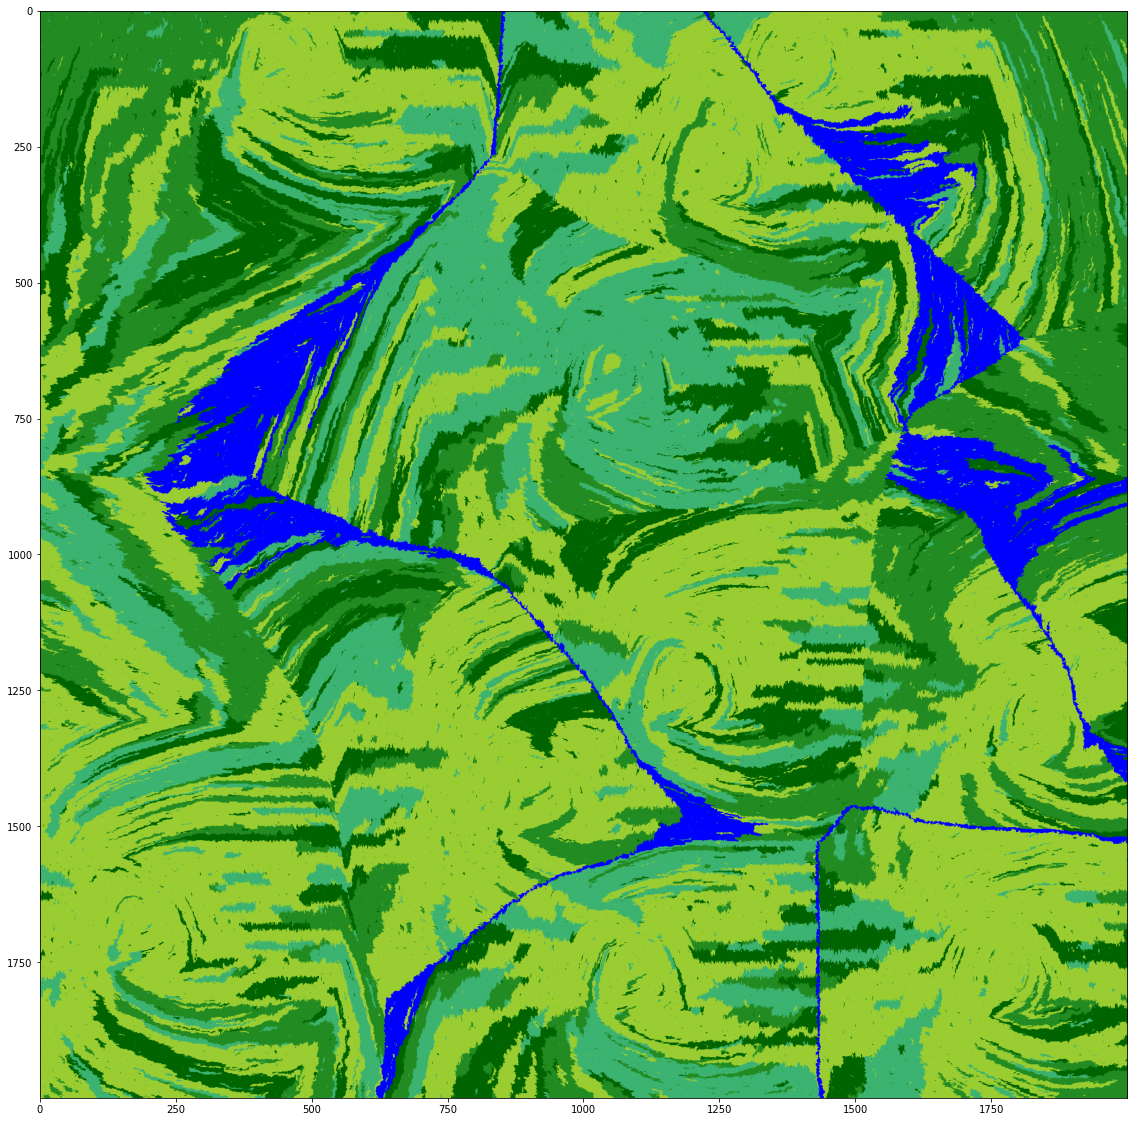

<Figure size 1440x1440 with 0 Axes>

In [13]:
fig = plt.figure(figsize = (20,20))
b = board(99, (2000,2000), wind=np.array([0,0]))
b.populate(fig, mut = .45, stoch = .999) # gets last iteration, so we know number
#b.kindle(40,4)
#b.kindle(123,123)
b.draw(fig)
#for i in range(2500):
    #b.update()
    #if not i%100:
    #    b.draw(fig)
